**`Import all the necessary libraries`**

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# Ignore warnings
warnings.filterwarnings("ignore")
%matplotlib inline

**`Load the dataset and do perform data cleaning`**

In [2]:
df = pd.read_csv('hybrid-model-forecasting-dataset.csv')
df.dropna(axis=1, how='all', inplace=True)
df['Datetime']=pd.to_datetime(df['Datetime'], format='mixed')
df.set_index('Datetime', inplace=True)
df.index = pd.date_range(start=df.index[0],
                         periods=len(df), freq='H')

**`Initial EDA`**

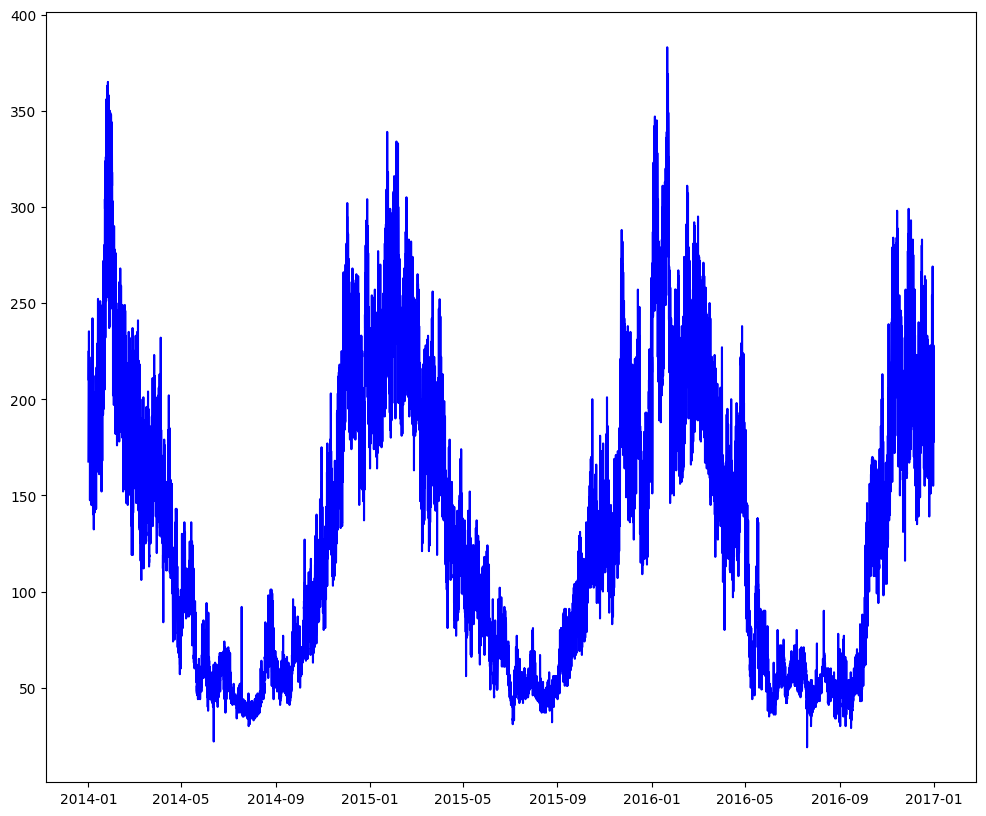

In [3]:
# Plotting x against y
plt.figure(figsize=(12, 10))  # Set the figure size
plt.plot(df['polloution'], color='blue')
plt.show()

**`Decompose the pollution time series into E, T, S`**

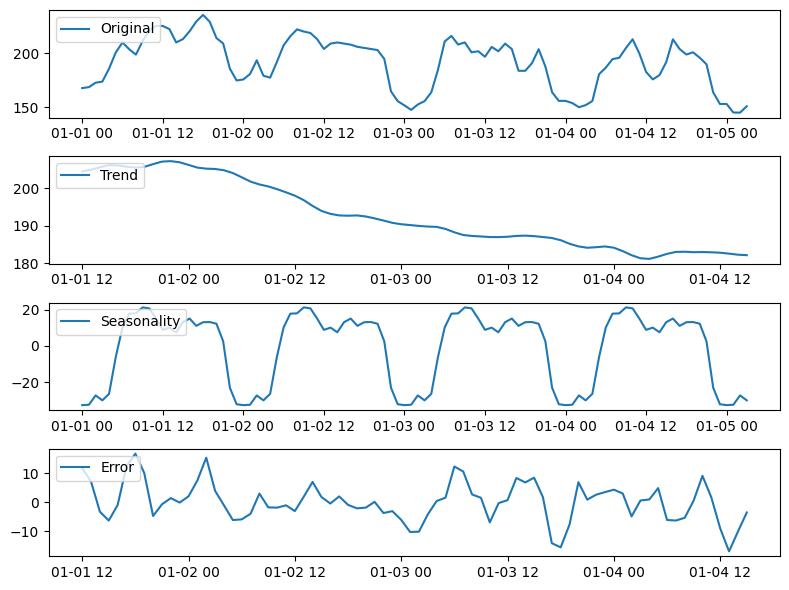

In [4]:
ts = df['polloution'][:100]

# Perform Error, Trend and Seasonal decomposition
result = seasonal_decompose(ts, model='additive')

# Plot the decomposition
plt.figure(figsize=(8, 6))

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Error')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [5]:
trnd = result.trend.dropna()
season = result.seasonal.dropna()
error = result.resid.dropna()

**`Train test split of Trend, Season and Error components`**

In [6]:
trend_train, trend_test = train_test_split(trnd, test_size=0.2, shuffle=False)
season_train, season_test = train_test_split(season, test_size=0.2, shuffle=False)
error_train, error_test = train_test_split(error, test_size=0.2, shuffle=False)

**`Check the stationarity of Seasonal data`**

In [18]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(season_train)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -6.004397167669599
p-value: 1.6285091161764663e-07
Critical Values: {'1%': -3.5319549603840894, '5%': -2.905755128523123, '10%': -2.5903569458676765}


**`Defining functions for model evaluation and hyper-parameter tuning`**

In [7]:
# Function to perform ARIMA model fitting and evaluation
def evaluate_arima_model(train_data, test_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test_data))
    error = mean_squared_error(test_data, predictions)
    return error

# Hyperparameter tuning
def evaluate_models(train_data, test_data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(train_data, test_data,
                                               order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f'ARIMA{order} MSE={mse:.3f}')
                except:
                    continue
    print(f'Best ARIMA{best_cfg} MSE={best_score:.3f}')
    return best_cfg

**`Evaluating ARIMA only on sample 100`**

ARIMA(23, 0, 10) MSE=197.369
ARIMA(23, 0, 11) MSE=192.647
ARIMA(23, 0, 12) MSE=199.410
ARIMA(23, 0, 13) MSE=196.767
ARIMA(23, 0, 14) MSE=251.319
ARIMA(23, 0, 15) MSE=204.622


ARIMA(23, 1, 10) MSE=192.086
ARIMA(23, 1, 11) MSE=189.071
ARIMA(23, 1, 12) MSE=190.656
ARIMA(23, 1, 13) MSE=180.459
ARIMA(23, 1, 14) MSE=160.307
ARIMA(23, 1, 15) MSE=219.768
ARIMA(24, 0, 10) MSE=199.142
ARIMA(24, 0, 11) MSE=212.009
ARIMA(24, 0, 12) MSE=208.000
ARIMA(24, 0, 13) MSE=94.833
ARIMA(24, 0, 14) MSE=212.565
ARIMA(24, 0, 15) MSE=214.519
ARIMA(24, 1, 10) MSE=168.058
ARIMA(24, 1, 11) MSE=179.911
ARIMA(24, 1, 12) MSE=198.013
ARIMA(24, 1, 13) MSE=185.080
ARIMA(24, 1, 14) MSE=263.415
ARIMA(24, 1, 15) MSE=175.104
ARIMA(25, 0, 10) MSE=197.173
ARIMA(25, 0, 11) MSE=201.766
ARIMA(25, 0, 12) MSE=205.068
ARIMA(25, 0, 13) MSE=196.245
ARIMA(25, 0, 14) MSE=208.143
ARIMA(25, 0, 15) MSE=202.698
ARIMA(25, 1, 10) MSE=174.746
ARIMA(25, 1, 11) MSE=183.375
ARIMA(25, 1, 12) MSE=186.682
ARIMA(25, 1, 13) MSE=197.399
ARIMA(25, 1, 14) MSE=225.135
ARIMA(25, 1, 15) MSE=198.299
ARIMA(26, 0, 10) MSE=197.417
ARIMA(26, 0, 11) MSE=200.919
ARIMA(26, 0, 12) MSE=202.397
ARIMA(26, 0, 13) MSE=209.423
ARIMA(26, 0, 14

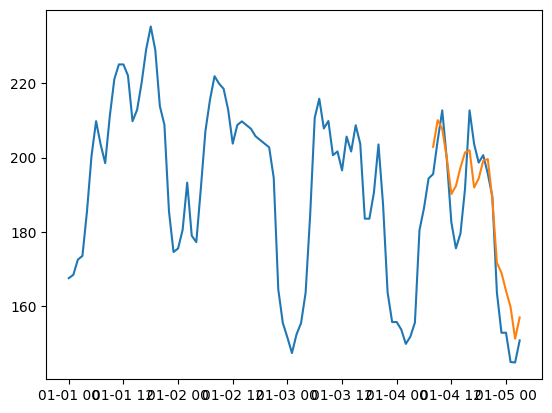

In [8]:
ts_data = ts

# Perform train-test split
train_size = int(len(ts_data) * 0.8)
train, test = ts_data.iloc[:train_size], ts_data.iloc[train_size:]

# Define the range of p, d, q values for hyperparameter tuning
p_values = range(23, 27)
d_values = range(0, 2)
q_values = range(10, 16)

# Find the best ARIMA hyperparameters
best_order = evaluate_models(train, test, p_values, d_values, q_values)

# Final model training
final_model = ARIMA(train, order=best_order)
final_model_fit = final_model.fit()

# Forecasting with the final model
forecast = final_model_fit.forecast(steps=len(test))
# 'forecast' contains predictions for the test setrange(0, 3)

# Evaluate the final model
mse = mean_squared_error(test, forecast)
print(f'Final ARIMA{best_order} MSE={mse:.3f}')

plt.plot(ts)
plt.plot(forecast)
plt.savefig('Arima only.png')

**`Evaluating pre-ETS-ARIMA model on sample 100`**

In [9]:
# Define the range of p, d, q values for hyperparameter tuning
p_values_trend = range(21, 26)
d_values_trend = range(0, 2)
q_values_trend = range(10, 13)

# Find the best ARIMA hyperparameters
best_order = evaluate_models(trend_train, trend_test, p_values_trend, 
                             d_values_trend,
                             q_values_trend)

# Final model training
final_model = ARIMA(trnd, order=best_order)
final_model_trend_fit = final_model.fit()


ARIMA(21, 0, 10) MSE=1.630


ARIMA(21, 0, 11) MSE=0.722
ARIMA(21, 0, 12) MSE=0.444
ARIMA(21, 1, 10) MSE=0.941
ARIMA(21, 1, 11) MSE=1.052
ARIMA(21, 1, 12) MSE=0.833
ARIMA(22, 0, 10) MSE=0.458
ARIMA(22, 0, 11) MSE=0.703
ARIMA(22, 0, 12) MSE=0.972
ARIMA(22, 1, 10) MSE=1.296
ARIMA(22, 1, 11) MSE=0.868
ARIMA(22, 1, 12) MSE=1.001
ARIMA(23, 0, 10) MSE=1.861
ARIMA(23, 0, 11) MSE=2.542
ARIMA(23, 0, 12) MSE=0.627
ARIMA(23, 1, 10) MSE=0.755
ARIMA(23, 1, 11) MSE=0.823
ARIMA(23, 1, 12) MSE=0.612
ARIMA(24, 0, 10) MSE=2.063
ARIMA(24, 0, 11) MSE=0.902
ARIMA(24, 0, 12) MSE=2.740
ARIMA(24, 1, 10) MSE=0.658
ARIMA(24, 1, 11) MSE=1.300
ARIMA(24, 1, 12) MSE=0.927
ARIMA(25, 0, 10) MSE=0.426
ARIMA(25, 0, 11) MSE=0.556
ARIMA(25, 0, 12) MSE=0.591
ARIMA(25, 1, 10) MSE=0.964
ARIMA(25, 1, 11) MSE=1.609
ARIMA(25, 1, 12) MSE=1.433
Best ARIMA(25, 0, 10) MSE=0.426


In [10]:
# Define the range of p, d, q values for hyperparameter tuning
p_values_season = range(21, 26)
d_values_season = range(0, 1)
q_values_season = range(10, 13)

# Find the best ARIMA hyperparameters
 = evaluate_models(season_train, season_test, p_values_season,
                             d_values_season,
                             q_values_season)

# Final model training
final_model = ARIMA(season, order=best_order)
final_seasonal_model_fit = final_model.fit()


ARIMA(21, 0, 10) MSE=1.691
ARIMA(21, 0, 11) MSE=1.252
ARIMA(21, 0, 12) MSE=0.535
ARIMA(22, 0, 10) MSE=1.940
ARIMA(22, 0, 11) MSE=1.766
ARIMA(22, 0, 12) MSE=0.552
ARIMA(23, 0, 10) MSE=0.973
ARIMA(23, 0, 11) MSE=1.523
ARIMA(23, 0, 12) MSE=0.392
ARIMA(24, 0, 10) MSE=0.422
ARIMA(24, 0, 11) MSE=0.446
ARIMA(24, 0, 12) MSE=0.181
ARIMA(25, 0, 10) MSE=0.418
ARIMA(25, 0, 11) MSE=0.578
ARIMA(25, 0, 12) MSE=0.243
Best ARIMA(24, 0, 12) MSE=0.181


In [11]:
# Define the range of p, d, q values for hyperparameter tuning
p_values_error = range(22, 26)
d_values_error = range(0, 1)
q_values_error = range(10, 13)

# Find the best ARIMA hyperparameters
best_order = evaluate_models(error_train, error_test,
                             p_values_error,
                             d_values_error,
                             q_values_error)

# Final model training
final_model = ARIMA(error, order=best_order)
final_error_model_fit = final_model.fit()


ARIMA(22, 0, 10) MSE=59.459
ARIMA(22, 0, 11) MSE=59.401
ARIMA(22, 0, 12) MSE=58.196
ARIMA(23, 0, 10) MSE=43.668
ARIMA(23, 0, 11) MSE=43.847
ARIMA(23, 0, 12) MSE=49.442
ARIMA(24, 0, 10) MSE=43.474
ARIMA(24, 0, 11) MSE=45.538
ARIMA(24, 0, 12) MSE=44.721
ARIMA(25, 0, 10) MSE=43.992
ARIMA(25, 0, 11) MSE=46.184
ARIMA(25, 0, 12) MSE=49.314
Best ARIMA(24, 0, 10) MSE=43.474


**`Give the Start and End date of future Forecasting`**

**`Choose option 1 or 2 then run the next cells same`**

In [12]:
#OPTION 1: run this line to compare ARIMA only to pre-ETS-ARIMA
last_timestamp = train.index[-1]

In [13]:
#OPTION 2: run this line to forecast the future
last_timestamp = ts.index[-1]

In [14]:
# Calculate the start datetime for prediction
start_prediction= last_timestamp + pd.DateOffset(hours=1)
# Calculate the end datetime for prediction (12 hours after start)
end_prediction= start_prediction + pd.DateOffset(hours=20)

**`Do the future forecasting`**

In [15]:
# Forecasting Trend with the final model
trend_forecast = final_model_trend_fit.predict(start=start_prediction, end=end_prediction)

# Forecasting Seasonality with the final model
season_forecast = final_seasonal_model_fit.predict(start=start_prediction, end=end_prediction)

# Forecasting Errors with the final model
error_forecast = final_error_model_fit.predict(start=start_prediction, end=end_prediction)

**`REconstruct the predicted time series`**

In [16]:
pre_ets_arima_hypertune_tune_RECONSTRUCTED = trend_forecast+season_forecast+error_forecast

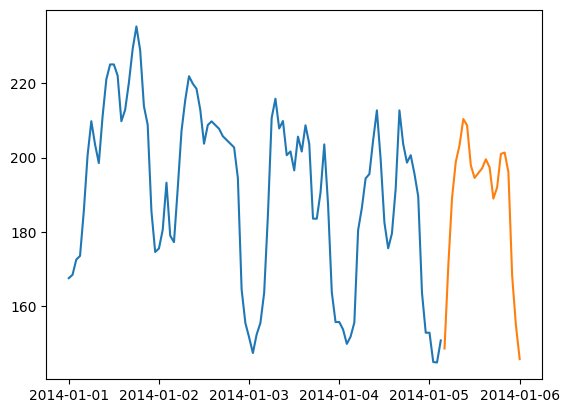

In [17]:
plt.plot(ts)
plt.plot(pre_ets_arima_hypertune_tune_RECONSTRUCTED)
plt.savefig('pre_ets_arima_hypertune_tune_RECONSTRUCTED.png')